## Simple Technical Analysis Using yFinance Package

This notebook creates a simple framework to perform simple technical analysis on individual stocks/baskets of stocks based on Yahoo Finance data. I wrote this as a way to mess around with time series data and find some different places to sink $20 into my Robinhood account. This is still considerably short of actual valid investment strategy, and will remain that way.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pandasql import sqldf

In [11]:
def bollingerbands(stock, days = 20, width = 2, present=True, df=None, plot=True, period='2y', cutoff=None):
    #Get data for an individual stock from Yahoo API
    if present:
        tick = yf.Ticker(stock)
        stockprices = tick.history(period=period)
        stockprices = stockprices.reset_index()
    #Option to import data from a pre-existing dataframe
    else:
        stockprices = df
        stockprices = stockprices.reset_index()
   
    #Calculate mean and std/moving avg
    stockprices['MA'] = stockprices['Close'].rolling(window=days).mean()
    stockprices['STD'] = stockprices['Close'].rolling(window=days).std() 
    stockprices['Upper'] = stockprices['MA'] + (stockprices['STD'] * width)
    stockprices['Lower'] = stockprices['MA'] - (stockprices['STD'] * width)
    stockprices['Year'] = stockprices['Date'].astype(str).str[0:4]
    #Create list of indices where there's a 'buy' and 'sell' over specified period
    #The sell list relies on having prior ownership of the stock and does not account for shorting - again a pretty major simplification
    b_list = []
    s_list = []
    #Number of distinct buys and average purchase price
    buys = 0
    p0 = 0
    #Running total of % profit made
    netgain = 0
    
    #Allows for slicing data by specific years
    if cutoff == None or period != '5y' or cutoff not in range(2016,2020,1):
        pass
    else:
        stockprices = sqldf("SELECT * FROM stockprices WHERE Year <=" + str(cutoff))
        stockprices = stockprices.reset_index()
    
    #Iterates over dataframe and finds instances where stock is under/overbought
    for i in range(len(stockprices)):
        if stockprices.loc[i,'Close'] < stockprices.loc[i,'Lower']:
            buys += 1
            p0 += stockprices.loc[i,'Close']
            b_list.append([stockprices.loc[i,'Date'],stockprices.loc[i,'Close']])
        if stockprices.loc[i,'Close'] > stockprices.loc[i,'Upper'] and buys > 0:
            netgain += (buys * stockprices.loc[i,'Close'] - p0)/p0
            buys = 0
            p0 = 0
            s_list.append([stockprices.loc[i,'Date'],stockprices.loc[i,'Close']])
    
    #Plots the graph including buys/sells
    stockprices = stockprices.set_index('Date')
    stockprices[['Close','MA','Upper','Lower']].plot(figsize=(10,4))
    if not plot:
        return(netgain)
    else:
        for point in b_list:
            plt.plot(point[0],point[1],'sk')
        for point in s_list:
            plt.plot(point[0],point[1],'sg')

        plt.grid(True)
        plt.title(stock + ' Bollinger Bands')
        plt.axis('tight')
        plt.ylabel('Price')
        return(netgain)

In [12]:
#This function checks to see if specific stocks are currently 'underbought' similar to bollingerbands function
def underbought_check(stock, days=20, width = 1.75, present=True, df=None):
    #Get data from API
    if present:
        tick = yf.Ticker(stock)
        stockprices = tick.history(period='1y')
        stockprices = stockprices.reset_index()
    #Option for importing the data from a separate dataframe with past historical data
    else:
        stockprices = df
        stockprices = stockprices.reset_index()
    
    #Calculates necessary metrics over an unneccessarily long period of time
    try:
        #Calc mean and std/ma
        stockprices['MA'] = stockprices['Close'].rolling(window=days).mean()
        stockprices['STD'] = stockprices['Close'].rolling(window=days).std() 
        stockprices['Upper'] = stockprices['MA'] + (stockprices['STD'] * width)
        stockprices['Lower'] = stockprices['MA'] - (stockprices['STD'] * width)
        i = len(stockprices) - 1
        #Checks most recent index to see if stock is currently underbought
        if (stockprices.loc[i,'Close'] < stockprices.loc[i,'Lower']):
            return 1
        else:
            return 0
    except KeyError:
        return -1

#Same as above, but checks to see if stock is overbought
def overbought_check(stock, days=20, width = 1.75, present=True, df=None):
    #Get data from API
    if present:
        tick = yf.Ticker(stock)
        stockprices = tick.history(period='2y')
        stockprices = stockprices.reset_index()
    else:
        stockprices = df.reset_index()
    try:
        #Calc mean and std/ma
        stockprices['MA'] = stockprices['Close'].rolling(window=days).mean()
        stockprices['STD'] = stockprices['Close'].rolling(window=days).std() 
        stockprices['Upper'] = stockprices['MA'] + (stockprices['STD'] * width)
        stockprices['Lower'] = stockprices['MA'] - (stockprices['STD'] * width)
        i = len(stockprices) - 1
        if (stockprices.loc[i,'Close'] > stockprices.loc[i,'Upper']):
            return 1
        else:
            return 0
    except KeyError:
        return -1

In [32]:
#A function that uses a trio of moving averages in ascending order to determine when to buy/sell
def ma_test(stock,asc=False,ma_a = 20, ma_b = 50, ma_c = 100, period='2y'):
    #Getting data from API
    tick = yf.Ticker(stock)
    stockprices = tick.history(period=period)
    stockprices = stockprices.reset_index()
   
    #Calc three moving averages according to function call
    stockprices['MA_1'] = stockprices['Close'].rolling(window=ma_a).mean()
    stockprices['MA_2'] = stockprices['Close'].rolling(window=ma_b).mean()
    stockprices['MA_3'] = stockprices['Close'].rolling(window=ma_c).mean()
    stockprices['Year'] = stockprices['Date'].astype(str).str[0:4]
    
    #Dates and indices where criteria is met
    d_list = []
    i_list = []
    for i in range(20,len(stockprices)-1):
        if stockprices.loc[i,'MA_1'] > stockprices.loc[i,'MA_2'] and stockprices.loc[i,'MA_2'] > stockprices.loc[i,'MA_3']:
            d_list.append(stockprices.loc[i,'Date'])
            i_list.append(i)
    #Determining when to buy/sell
    b_list = []
    s_list = []
    for i in i_list:
        if i-1 not in i_list and i+1 in i_list:
            b_list.append(i)
        if i-1 in i_list and i+1 not in i_list:
            s_list.append(i)
    
    #Determining total cost of buying and gain from selling
    p0 = 0
    p1 = 0
    for b in b_list:
        p0 += stockprices.loc[b,'Close']
    for s in s_list:
        p1 += stockprices.loc[s,'Close']
    
    #Plotting
    stockprices = stockprices.reset_index()
    stockprices = stockprices.set_index('Date')
    
    stockprices[['Close','MA_1','MA_2','MA_3']].plot(figsize=(10,4))
    
    for point in d_list:
        plt.axvline(point, color = 'g', alpha = 0.15)

    plt.grid(True)
    plt.title(stock + ' Moving Averages (' + str(ma_a) + ', ' + str(ma_b) + ', ' + str(ma_c) +')')
    plt.axis('tight')
    plt.ylabel('Price')
    #Return % gain
    return (p1 - p0)/p0

In [33]:
#Function to calculate net return from holding stock over specified period
def default_return(stock, period='2y'):
    tick = yf.Ticker(stock)
    stockprices = tick.history(period=period)
    stockprices = stockprices.reset_index()
    p0 = stockprices.loc[0,'Close']
    p1 = stockprices.loc[len(stockprices)-1,'Close']
    return (p1-p0)/p0

In [34]:
#Creates a class to perform all these functions at once
class Basket:
    def __init__(self,stocks=[],per='2y'):
        self.stocklist = stocks
        self.period = per
        self.boll_return = {}
        self.ma_return = {}
        self.def_return = {}
        self.custom_dicts = []
    def add_tick(self,ticker):
        self.stocklist.append(ticker)
    def get_stocklist(self):
        return self.stocklist
    def bolltest(self,w=2, d=20):
        for tick in self.stocklist:
            self.boll_return[tick] = bollingerbands(tick,width=w,days=d,period =self.period)
    def get_bolltest(self):
        return self.boll_return
    def update_return(self):
        for tick in self.stocklist:
            self.def_return[tick] = default_return(tick,period=self.period)
    def get_defret(self):
        return self.def_return
    def ma_test(self,m1=20,m2=50,m3=100):
        for tick in self.stocklist:
            self.ma_return[tick] = ma_test(tick,ma_a = m1,ma_b=m2,ma_c=m3,period=self.period)
    def get_ma_test(self):
        return self.ma_return
    def add_custom_dict(self,custom_dict):
        self.custom_dicts.append(custom_dict)
    def get_custom_dict(self,ind=0):
        return self.custom_dicts[ind]
    def get_overbought(self, d=20,w=2):
        ob_list = []
        for ticker in self.stocklist:
            if overbought_check(ticker,days=d,width=w) == 1:
                ob_list.append(ticker)
        return ob_list
    def get_underbought(self, d=20,w=2):
        ub_list = []
        for ticker in self.stocklist:
            if underbought_check(ticker,days=d,width=w) == 1:
                ub_list.append(ticker)
        return ub_list

-0.1092328189158292

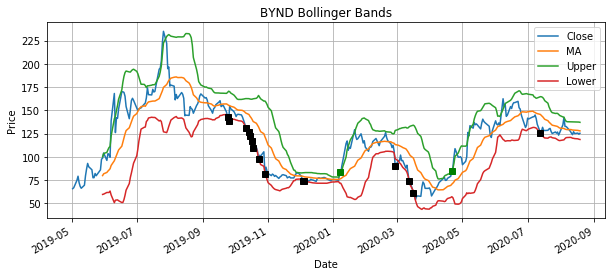

In [35]:
bollingerbands('BYND')

In [36]:
s = Basket(['AAPL','TSLA'])

{'AAPL': 1.2031130997715154, 'TSLA': 5.09042277266243}
['TSLA']


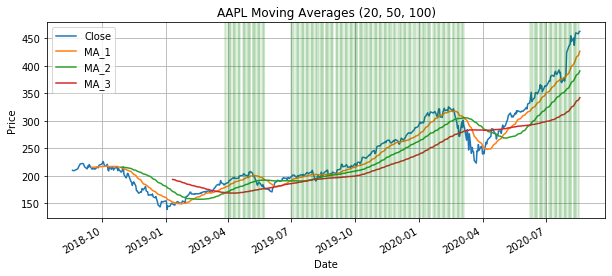

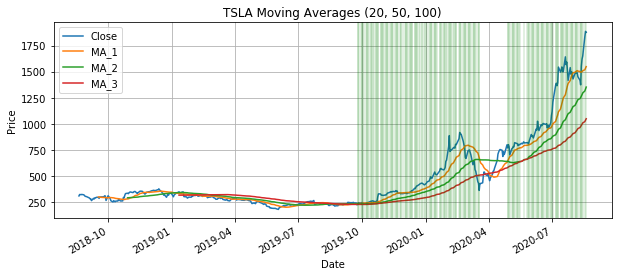

In [37]:
s.ma_test()
s.update_return()
#print(s.get_ma_test())
print(s.get_defret())
print(s.get_overbought())